<a href="https://colab.research.google.com/github/nyculescu/kaggle__competitive_data_science_predict_future_sales/blob/master/01_kernel_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Input files

* shops.csv- supplemental information about the shops -- `61 entries`
    * shop_name (e.g., "СПб ТК ""Сенная""")
    * shop_id (e.g., 43)

* item_categories.csv  - supplemental information about the items categories -- `85 entries`
    * item_category_name (e.g., Кино - DVD)
    * item_category_id (e.g., 40)

* items.csv - supplemental information about the items/products -- `22.171 entries`
    * item_name (e.g., 1812: 4 СЕРИИ (регион))
    * item_id (e.g., 97)
    * item_category_id (e.g., 40)

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015 -- `2.935.850 entries | 587.170 entries should be allotted to the training set`
    * <strike>date (e.g., 23.02.2013)</strike> *I don't see the reason of using this in ML training because we already have date_block_num as an attribute*
    * date_block_num (e.g., 1)
    * shop_id (e.g., 43) - `shop_id and item_id shall be concatenated to ID`
    * item_id (e.g., 97) - `shop_id and item_id shall be concatenated to ID`
    * item_price (e.g., 149.0)
    * item_cnt_day (e.g., 1.0)

* sample_submission.csv - a sample submission file in the correct format -- `214.201 entries`
    * ID (e.g., 0)
    * item_cnt_month (e.g., 0.5)

* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015 -- `214.201 entries`
    * ID (e.g., 0)
    * shop_id (e.g., 43)
    * item_id (e.g., 97)

## Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


# Frame the problem and look at the big picture

## The objective: what needs to be done?
The task is to forecast the total amount of products sold in every shop for the test set.

! Note that the list of shops and products slightly changes every month.

## Frame this problem
* typical supervised learning task - we have the labeled training examples
* typical regression task - we're asked to predict a value
    * multiple regression problem (value prediction) - the system will use multiple features to make a prediction
    * also univariate regression problem - we're only trying to predict a single value (*total amount of products sold*) in every *shop*
* plain batch learning - we don't have a continuous flow of data coming to the system - the data doesn't need to be adjusted rapidly, and the data is small enoug to fit in memory (`is it so?`)


In [0]:
### run ###

import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import sklearn.linear_model

In [6]:
### run in Colab ###

from google.colab import drive
drive.mount('/content/drive')

sales_train = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/sales_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### run in VS Code ###

sales_train = pd.read_csv(os.path.abspath(os.path.join('input', 'sales_train.csv')))

In [0]:
sales_train.head()
sales_train.head(-5)

In [0]:
sales_train.info()

In [0]:
# see the amount of memory used (in bytes) for each column. 
# It’s useful when building machine learning models which may require a lot memory in training.
sales_train.memory_usage(deep=True)

We can find out what categories exist and how many districts belong to each category by using the value_counts() method, but we know them already (form the description)

In [0]:
## Var 1
# For numeric data, the result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles.
# For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items.

sales_train.describe(include='all')

In [0]:
### run ###

# the "date" field doesn't look to be relevant, so drop it
sales_train.drop("date", axis=1, inplace=True)

In [0]:
### run ###

## Var 2 - print the entire number in Python from describe() function, but only for the numeric data

def describe_entire_nrs(datafr):
    desc = datafr.describe() # include='all' will not work
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
    return desc

In [10]:
describe_entire_nrs(sales_train)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2935849,2935849,2935849,2935849
mean,14.57,33.00,10197.23,890.85,1.24
std,9.42,16.23,6324.30,1729.80,2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,4476.00,249.00,1.00
50%,14.00,31.00,9343.00,399.00,1.00
75%,23.00,47.00,15684.00,999.00,1.00
max,33.00,59.00,22169.00,307980.00,2169.00


There are values below 0 for item_cnt_day and item_price -- I don't see any reason, so I will not consider these values and delete the whole row which contains them.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13062d1518>,
      dtype=object)

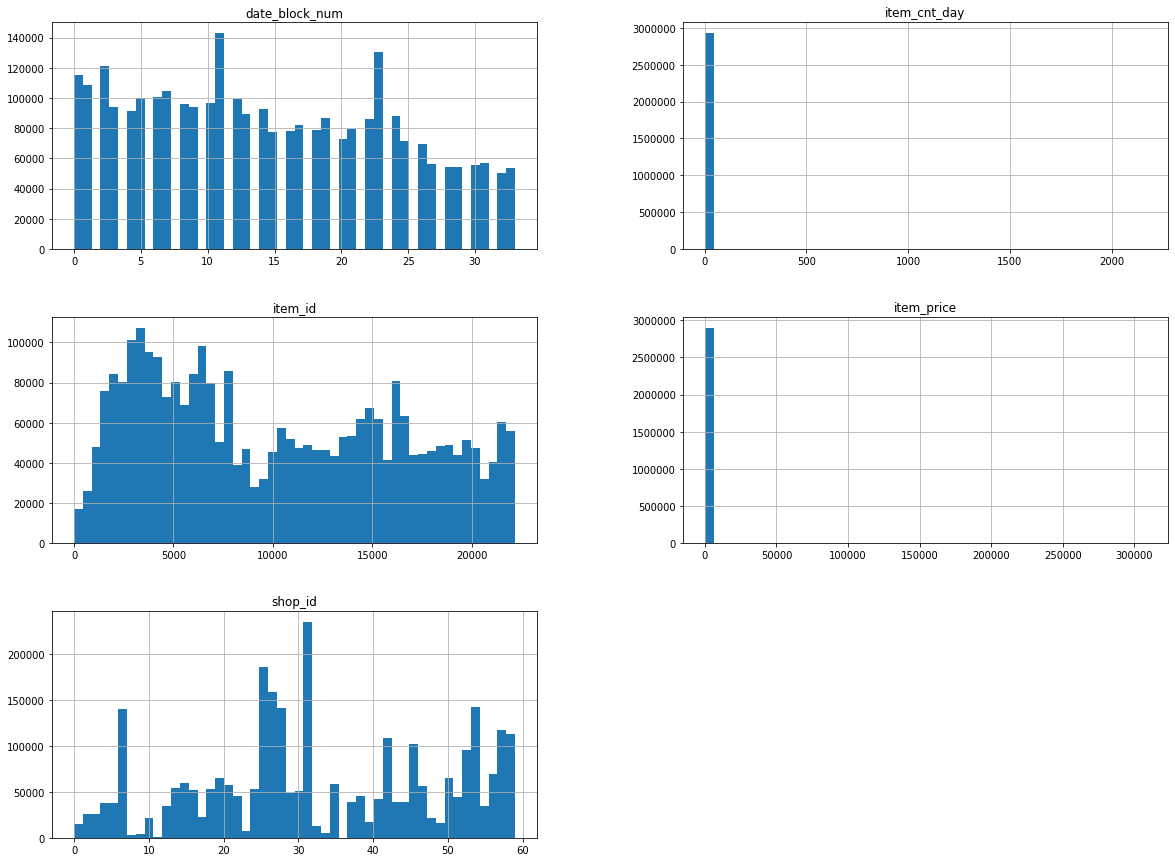

In [12]:
sales_train.hist(bins=50, figsize=(20,15))
# plt.show()

In [4]:
# cleanup the rows which have the item_cnt_day and item_price with negative values
sales_train = sales_train[~(sales_train['item_cnt_day'] < 0)]
sales_train = sales_train[~(sales_train['item_price'] < 0)]

NameError: ignored

observations on th plotted dataframe:
* date_block_num, item_id, shop_id are capped -- Warning from hands-on book: The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit.
    * date_block_num even capped, doesn't look to be a problem
* These attributes have very different scales
* item_cnt_day and item_price don't express anything


## Looking for Correlations

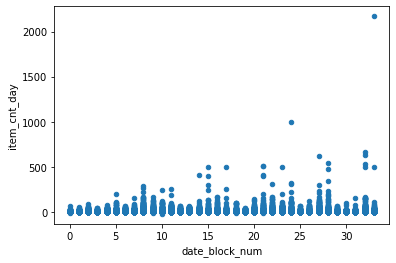

In [9]:
sales_train.plot(kind="scatter", x="date_block_num", y="item_cnt_day")

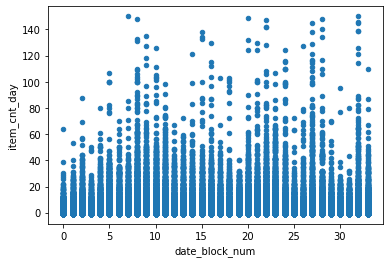

In [10]:
sales_train_outl = sales_train[~(sales_train['item_cnt_day'] > 150)] # ignore the outliers
sales_train_outl = sales_train_outl[~(sales_train_outl['item_cnt_day'] < -1)] # ignore the outliers
sales_train_outl.plot(kind="scatter", x="date_block_num", y="item_cnt_day")

In [40]:
cnt_i = [0] * (sales_train_outl["shop_id"].max() + 1)
for i in sales_train_outl["shop_id"]:
    cnt_i[i] += 1

# for i in cnt_i:
#     print(cnt_i.index(i) + 1, i)

print("max value: ", np.where(cnt_i == np.amax(cnt_i))[0], np.amax(cnt_i)) # Find max value & its index

max value:  [31] 235182


In [33]:
describe_entire_nrs(sales_train_)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,235182,235182,235182,235182,235182
mean,14.93,31.00,11095.57,724.18,1.32
std,9.54,0.00,6176.51,1382.63,2.06
min,0.00,31.00,26.00,0.10,1.00
25%,7.00,31.00,5613.00,199.00,1.00
50%,14.00,31.00,11292.00,369.00,1.00
75%,23.00,31.00,16205.00,789.00,1.00
max,33.00,31.00,22167.00,35991.00,133.00


In [0]:
sales_train_outl = sales_train_outl[sales_train_outl["shop_id"] == (32-1)] # drop te rows which doesn't have the shop_id equal to 31

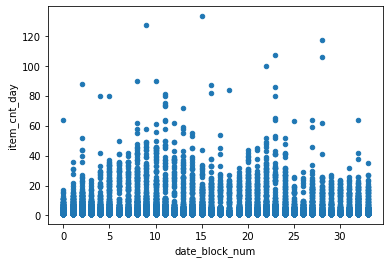

In [44]:
lin1 = sklearn.linear_model.Ridge(alpha=0.01)

Xsample1 = np.c_[sales_train_outl["date_block_num"]]
ysample1 = np.c_[sales_train_outl["item_cnt_day"]]
lin1.fit(Xsample1, ysample1)
t0 = lin1.intercept_[0]
t1 = lin1.coef_[0][0]

sales_train_outl.plot(kind='scatter', x="date_block_num", y='item_cnt_day')
y = np.linspace(sales_train_outl["date_block_num"].min(), sales_train_outl["date_block_num"].max())
plt.plot(y, t0 + t1*y, "r+")

In [0]:
# sales_train["item_cnt_day", "shop_id"].mean()

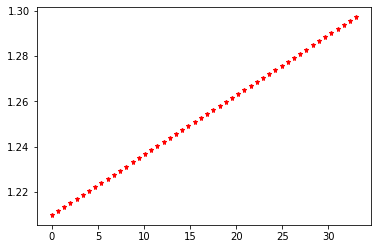

In [28]:
plt.plot(X, t0 + t1*X, linestyle='none', marker='*', markersize=5, color='red')

In [0]:
corr_matrix = train_set.corr()
corr_matrix["item_cnt_day"].sort_values(ascending=False)

In [0]:
attributes = ["date_block_num", "item_cnt_day", "item_price", "shop_id", "item_id"]
scatter_matrix(train_set[attributes], figsize=(12, 8)) 

Some correlations found:
* date_block_num vs item_cnt_day - more and more items are sold
* date_block_num vs item_price - more and more expensive items are sold
* shop_id vs item_cnt_day - determine which shops sell more to less
* item_id vs item_cnt_day - determine which items are the most sold

Try out some various attribute combinations

---
### Compute a test set &darr;

In [0]:
### run ###

# compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [0]:
### run ###

sales_train_with_id = sales_train.reset_index()   # adds an `index` column

In [0]:
### run ###

# sales_train_with_id["id"] = sales_train["shop_id"] * 100 + sales_train["item_id"] # (*1) the shop_id doesn't exceed value 99 for this project
train_set, test_set = split_train_test_by_id(sales_train_with_id, 0.2, "index") # if (*1) is used, replace "index" with "id"

In [0]:
describe_entire_nrs(train_set)

Compute a test set &uarr;
---

---
the other data from the CSVs &darr;

In [0]:
item_categories = pd.read_csv(os.path.abspath(os.path.join('input', 'item_categories.csv')))
items = pd.read_csv(os.path.abspath(os.path.join('input', 'items.csv')))
sample_submission = pd.read_csv(os.path.abspath(os.path.join('input', 'sample_submission.csv')))
shops = pd.read_csv(os.path.abspath(os.path.join('input', 'shops.csv')))
test = pd.read_csv(os.path.abspath(os.path.join('input', 'test.csv')))

In [0]:
item_categories.info()
item_categories.describe(include='all')

In [0]:
items.info()
items.describe(include='all')

In [0]:
sample_submission.info()
sample_submission.describe(include='all')

In [0]:
shops.info()
shops.describe(include='all')

In [0]:
test.info()
test.describe(include='all')

---
the other data from the CSVs &uarr;

In [0]:
train_set.info()

In [0]:
# train_set.plot(kind="scatter", x="date_block_num", y="item_cnt_day")

# -- or --
plt.scatter(train_set["date_block_num"], train_set["item_cnt_day"]) # in the notebook this gets stuck...
plt.show()

Select a Performance Measure -- A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

`todo`